# Analyze Facebook Data with IBM Watson services

In this Python 3.5 notebook, you'll learn how to enrich and analyze a combined data set of unstructured and structured information with IBM Watson services. You'll analyze a standard Facebook Analytics export that includes photos and text from posts, articles, and thumbnails, plus standard performance metrics, such as likes, shares, and impressions. You'll visualize the results with PixieDust.

This notebook runs on Python 3.5 with Spark 2.0.

This notebook has three main parts:

**Part I**: Use the IBM Watson Natural Language Understanding, Tone Analyzer, and Visual Recognition services to enrich the Facebook posts, thumbnails, and articles with image classification and these semantic features: emotion tones, social tones, language tones, entities, keywords, and document sentiment. The results of Part I will be features and metrics that you'll  visualize in Part III. 

**Part II**: Create pandas DataFrames for the three main features: tone, keywords, and entities. You'll use these DataFrames to find insights with the visualizations in Part III.

**Part III**: Visualize the post consumption by tone, entity, and keyword with PixieDust.

## Table of Contents 
### [Part I - Enrich the data](#part1)<br>
1. [Setup](#setup)<br>
   1.1 [Install the necessary packages](#setup1)<br>
   1.2 [Import packages and libraries](#setup2)<br>
   1.3 [Add your service credentials from Bluemix for the Watson services](#setup3)<br>
2. [Load the data and set variables](#load)<br>
    2.1 [Load the data](#load1)<br>
    2.2 [Set variables](#load2)<br>
3. [Prepare the data](#prepare)<br>
   3.1 [Cleanse the data](#prepare1)<br>
   3.2 [Extract thumbnails and extended links](#prepare2)<br>
4. [Enrich the data](#enrich)<br>
   4.1 [Enrich the post text with NLU](#enrich1)<br>
   4.2 [Enrich the thumbnail text with NLU](#enrich2)<br>
   4.3 [Enrich the article text with NLU](#enrich3)<br>
   4.4 [Run Tone Analyzer on the post text](#tonepost)<br>
   4.5 [Run Tone Analyzer on the article text](#tonearticle)<br>
   4.6 [Classify images with Visual Recognition](#imageclass)<br>
5. [Save the enriched DataFrame to object storage](#write)<br>
    
### [Part II - Prepare the data](#part2)<br>
1. [Sort data by feature](#p2prepare)<br>
   1.1 [Create a list of metrics](#visualizations)<br>
   1.2 [Create a consolidated tone DataFrame](#tone)<br>
   1.3 [Create a consolidated keyword DataFrame](#keyword)<br>
   1.4 [Create a consolidated entity DataFrame](#entity)<br>
  
### [Part III - Analyze the data](#part3)<br>

1. [Define variables](#2setup)<br> 
2. [Visualize the data with PixieDust](#viz)<br>
   2.1 [View post consumption by tone](#viz1)<br>
   2.2 [View post consumption by entity](#viz2)<br>
   2.3 [View post consumption by keyword](#viz3)<br>

### [Summary](#summary) 

# <a id="part1"></a> Part I: Enrich the data

## <a id='setup'></a> 1. Setup
To prepare your environment, you need to install some packages and enter credentials for the two Watson services.

### <a id="setup1"></a>1.1 Install the necessary packages
You need the latest versions of these packages:
 - Watson Developer Cloud: a client library for Watson services.
 - <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/" target="_blank" rel="noopener noreferrer">Beautiful Soup</a>: a library to parse data from HTML for enriching the Facebook data.
 - <a href="https://ibm-cds-labs.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a>: a library to visualize the data. 

Install the Watson Developer Cloud package:

In [ ]:
!pip install --upgrade watson-developer-cloud

Install the Beautiful Soup package:

In [ ]:
!pip install --upgrade beautifulsoup4

Install the PixieDust package, unless you installed PixieDust locally from source and want to continue to run PixieDust from source:

In [ ]:
!pip install --user --upgrade pixiedust

Now restart the kernel by choosing **Kernel > Restart**.

### <a id="setup2"></a>1.2 Import packages and libraries
Import the packages and libraries that you'll use:

In [1]:
import json
import sys
import watson_developer_cloud
from watson_developer_cloud import ToneAnalyzerV3, VisualRecognitionV3
import watson_developer_cloud.natural_language_understanding.features.v1 as features

import operator
from functools import reduce
from io import StringIO
import numpy as np
from bs4 import BeautifulSoup as bs
from operator import itemgetter
from os.path import join, dirname
import pandas as pd
import numpy as np
import requests
import pixiedust

Pixiedust database opened successfully


### <a id='setup3'></a>1.3 Add your service credentials from Bluemix for the Watson services

You must create a Watson Natural Language Understanding service, a Watson Tone Analyzer service, and a Watson Visual Recognition service on [Bluemix](bluemix.net).

1. Create a service for [Natural Language Understanding (NLU)](https://www.ibm.com/watson/developercloud/natural-language-understanding.html). 
1. Create a service for [Tone Analyzer](https://console.ng.bluemix.net/catalog/services/tone-analyzer?taxonomyNavigation=watson).
1. Create a service for [Visual Recognition](https://console.ng.bluemix.net/catalog/services/visual-recognition).
1. Insert the username and password values for your NLU and Tone Analyzer services and the API key for your Visual Recognition service in the following cell. Do not change the values of the `version` fields.
1. Run the cell.

In [ ]:
nlu = watson_developer_cloud.NaturalLanguageUnderstandingV1(version='2017-02-27', 
                                                            username='YOUR USER NAME', 
                                                            password='YOUR PASSWORD') 
tone_analyzer = ToneAnalyzerV3(version='2016-05-19', 
                               username='YOUR USER NAME', 
                               password='YOUR PASSWORD') 

visual_recognition = VisualRecognitionV3('2016-05-20', api_key='YOUR API KEY')

## <a id='load'></a> 2. Load the data and set variables

The data you'll analyzing is a sample of a standard export of the Facebook Insights Post information from the <a href="https://www.facebook.com/ibmwatson/" target="_blank" rel="noopener noreferrer">IBM Watson Facebook page</a>. Engagement metrics such as clicks, impressions, and so on, are altered and do not reflect actual post performance data. The data is on the DSX community page.

### <a id='load1'></a>2.1 Load the data
To get the data and load it into a pandas DataFrame:

1. Go to the [Watson Facebook data card](https://apsportal.ibm.com/exchange/public/entry/view/ebaf6aab3f42217a22fb787d296fde9d) and click the download icon to save the file on your computer.
1. Back in your notebook, load the file by clicking the **Find and Add Data** icon and then dragging and dropping the file onto the pane or browsing for the file. The data is stored in the object storage container that is associated with your project.
1. Click in the next cell and then choose **Insert to code > Insert Pandas DataFrame** from below the file name and then run the cell.

In [3]:
# click in this cell and then insert a pandas DataFrame


,Post ID,Permalink,Post Message,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,Lifetime Post organic reach,...,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative feedback - unlike_page_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Lifetime Negative Feedback from Users by Type - unlike_page_clicks
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lifetime: The total number of people your Page...,Lifetime: The number of people who saw your Pa...,...,NaN,Lifetime: The number of clicks anywhere in you...,NaN,NaN,Lifetime: The number of people who have given ...,NaN,NaN,Lifetime: The number of times people have give...,NaN,NaN
1,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Cheers to a wonderful New Year with Chef Watso...,Photo,NaN,NaN,12/31/15 6:28,,2291,2291,...,4.0,21,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,IBM Watson's cover photo,Photo,NaN,NaN,12/31/15 6:26,,158,158,...,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,NaN,NaN
3,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,What is Watson? IBM Watson is a technology pla...,Photo,NaN,NaN,12/30/15 7:00,,4203,4203,...,67.0,26,102.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
4,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Did you know that we have been hosting a serie...,Photo,NaN,NaN,12/28/15 7:05,,2847,2847,...,62.0,19,37.0,83.0,1,NaN,NaN,1,NaN,NaN


### <a id='load2'></a>2.2 Set variables
You need to set these variables:
 - The name of the DataFrame
 - Your credentials for the source file
 - A file name for the enriched DataFrame
 
Define a variable, `df`, for the DataFrame that you just created. If necessary, change the original DataFrame name to match the one you created.

In [4]:
df = df_data_1

You'll need to use your credentials when you save the DataFrame to a file.

To define a credentials variable:
 1. Click in the cell below.
 2. On the **Files** pane, choose **Insert to code > Insert Credentials** from below the orginal file name. 
 3. Make sure the name of the variable is `credentials_1` in the first line and then run the cell.

In [5]:
# click in this cell and then insert your credentials


You'll save the enriched data to your project object storage. Give the file a name:

In [6]:
# replace YOUR FILE NAME with a file name 
localfilename = 'YOURFILENAME.csv'

## <a id='prepare'></a>3. Prepare the data

You'll prepare the data by cleansing it and extracting the URLs. Many of the posts contain both text and a URL. The first task is to separate URLs from the text so that they can be analyzed separately. Then you need to get thumbnails for the photos and links, and convert any shortened URLs to full URLs.

### <a id='prepare1'></a> 3.1 Cleanse the data
To cleanse the data, you'll rename a column and add a column with the URLs that were embedded in the post. 

Change the name of the `Post Message` column to `Text`:

In [7]:
df.rename(columns={'Post Message': 'Text'}, inplace=True)

In [8]:
df = df.drop([0])
#df.head()

Use the `str.partition` function to remove strings that contain "http" and "www" from the `Text` column and save them in new DataFrames, then add all web addresses to a new `Link` column in the original DataFrame. This process captures all web addresses: https, http, and www.

In [9]:
df_http= df["Text"].str.partition("http")
df_www = df["Text"].str.partition("www")

#combine delimiters with actual links
df_http["Link"] = df_http[1].map(str) + df_http[2]
df_www["Link1"] = df_www[1].map(str) + df_www[2]

#include only Link columns 
df_http.drop(df_http.columns[0:3], axis=1, inplace = True)
df_www.drop(df_www.columns[0:3], axis=1, inplace = True)

#merge http and www dataframes
dfmerge = pd.concat([df_http, df_www], axis=1)

#the following steps will allow you to merge data columns from the left to the right
dfmerge = dfmerge.apply(lambda x: x.str.strip()).replace('', np.nan)

#use fillna to fill any blanks with the Link1 column
dfmerge["Link"].fillna(dfmerge["Link1"], inplace = True)

#delete Link1 (www column)
dfmerge.drop("Link1", axis=1, inplace = True)

#combine Link data frame 
df = pd.concat([dfmerge,df], axis = 1)

# # make sure text column is a string
df["Text"] = df["Text"].astype("str")

# #strip links from Text column
df['Text'] = df['Text'].apply(lambda x: x.split('http')[0])
df['Text'] = df['Text'].apply(lambda x: x.split('www')[0])


### <a id='prepare2'></a> 3.2 Extract thumbnails and extended links

A standard Facebook export does not provide the thumbnail that usually summarizes the link or photo associated with each post. Use the Beautiful Soup library to go into the HTML of the post and extract the thumbnail text:

In [10]:
#Pull thumbnail descriptions using beautiful soup
#changes links from objects to strings
for link in df.Link:
    df.Link.to_string()
    
#create empty list to store descriptions    
description = []

#use BeautifulSoup to pull descriptions from links 
for url in df["Link"]:
    try:
        #if there's no description
        if pd.isnull(url):
            description.append("")
        else:
            page3= requests.get(url)
            soup3= bs(page3.text,"lxml")
            #Capture both capatalized 'Description' and lower case
            desc= soup3.find(attrs={'name':'Description'})
            if desc == None:
                desc= soup3.find(attrs={'name':'description'})
            description.append(desc['content'])
            
    #this exception will save you from 404 errors
    except Exception:
        description.append("")
        continue
        
#save to df and add column titled 'Thumbnails'
df["Thumbnails"] = description
#df['Thumbnails'].head()
#df.head()

Show the first five thumbnails:

In [11]:
df['Thumbnails'].head()

1                                                     
2                                                     
3    IBM Watson is a cognitive system enabling a ne...
4    Get insights on building with Watson APIs and ...
5    The page you requested cannot be displayed (HT...
Name: Thumbnails, dtype: object

Use the Beautiful Soup library to find the images in posts and save them in a new column:

In [12]:
piclinks = []

for url in df["Link"]:
    try:
        if pd.isnull(url):
            piclinks.append("")
        else: 
            page3= requests.get(url)
            soup3= bs(page3.text,"lxml")
            pic = soup3.find('meta', property ="og:image")
            if pic:
                piclinks.append(pic["content"])
            else: 
                piclinks.append("")
    except:
        piclinks.append("")
df["Image"] = piclinks 

The Natural Language Understanding service requires full URLs. However, many of the Watson Facebook posts include shortened URLs.

Use the Beautiful Soup library to find the full URLs and save them in a new column:

In [13]:
#convert shortened links to their original form

shortlink = df["Link"]
extendedlink = []

for link in shortlink:
    #create empty list to store   
    try:
        extended_link = requests.Session().head(link, allow_redirects=True).url
        extendedlink.append(extended_link)
    except:
         # catch *all* exceptions
        e = sys.exc_info()[0]
        extendedlink.append('')
        pass
df["Extended Links"] = extendedlink

## <a id='enrich'></a> 4. Enrich the data

It's enrichment time! 

First you'll run NLU scripts to add keywords and entities information for the post text, the thumbnails text, and the text from linked articles. Then you'll run Tone Analyzer scripts to gather the top social, writing, and emotion tones from the post text and the text from linked articles. And finally, you'll run a Visual Recognition script to classify the images.

### <a id='enrich1'></a> 4.1 Enrich the post text with NLU
The following script is an example of how to use Natural Language Understanding to iterate through each post and extract enrichment features for future analysis.

For this example, `free_form_responses` is set the `Text` column in our DataFrame, which contains the text of each post. NLU can also iterate through a column of URLs, or other freeform text. There's a list within a list for the Keywords and Entities features to allow gathering multiple entities and keywords from each piece of text.

Each extracted feature is appended to the DataFrame in a new column that's defined at the end of the script. If you want to run this same script for the other columns, set `free_form_responses` to the column name, if you are using URLs, change the `text=response` parameter to `url=response`, and update the new column names as necessary. 

In [14]:
# Extract the free form text response from the DataFrame
# If you are using this script for a different CSV, change this column name
free_form_responses = df['Text']
# define the list of enrichments to apply
# if you are modifying this script, add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(text=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append('0')

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append('0')

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append("")
            highestEmotionScore.append("")

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)
        else:
            kywords.append("")
            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        pass
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['TextOverallSentimentScore'] = overallSentimentScore

df['TextKeywords'] = kywords
df['TextEntities'] = entities


Now you have a column with multiple keywords and entities, separated by commas. For your analysis in Part II, you'll need the top keyword and entity for each post. 
Add two new columns to capture the `MaxTextKeyword` and `MaxTextEntity`:

In [15]:
#choose first of Keywords,Concepts, Entities
df["MaxTextKeywords"] = df["TextKeywords"].apply(lambda x: x.split(',')[0])
df["MaxTextEntity"] = df["TextEntities"].apply(lambda x: x.split(',')[0])
df.head()

,Link,Post ID,Permalink,Text,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,...,Image,Extended Links,TextHighestEmotion,TextHighestEmotionScore,TextOverallSentimentType,TextOverallSentimentScore,TextKeywords,TextEntities,MaxTextKeywords,MaxTextEntity
1,NaN,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Cheers to a wonderful New Year with Chef Watso...,Photo,NaN,NaN,12/31/15 6:28,,2291,...,,,joy,0.937670,positive,0.969574,"Chef Watson, Eve cocktails, wonderful New, Che...",Person,Chef Watson,Person
2,NaN,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,IBM Watson's cover photo,Photo,NaN,NaN,12/31/15 6:26,,158,...,,,joy,0.041239,neutral,0.000000,"IBM Watson, cover photo",Company,IBM Watson,Company
3,http://ibm.co/1mngjQu,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,What is Watson? IBM Watson is a technology pla...,Photo,NaN,NaN,12/30/15 7:00,,4203,...,,https://www.ibm.com/watson/,joy,0.040208,positive,0.086826,"natural language processing, IBM Watson, unstr...","Company, Person",natural language processing,Company
4,http://ibm.co/1IyCTpX,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Did you know that we have been hosting a serie...,Photo,NaN,NaN,12/28/15 7:05,,2847,...,http://www.ibm.com/watson/assets/img/cloud/her...,http://www.pages03.net/ibmwatson/building-with...,sadness,0.131855,positive,0.643113,"app building process, technical webinars",,app building process,
5,http://ibm.co/fb_1XVBwbz,187446750783_10153351555645784,https://www.facebook.com/ibmwatson/posts/10153...,Interested in applying social media analytics ...,Photo,NaN,NaN,12/27/15 7:00,,2514,...,,https://www-304.ibm.com/connections/blogs/pred...,joy,0.068561,positive,0.703211,"social media analytics, outcomes business chal...",JobTitle,social media analytics,JobTitle


Make sure the new columns have values. If they don't, check your NLU credentials in step 1.3.

### <a id='enrich2'></a> 4.2 Enrich thumbnail text with NLU 
Run the NLU script on the thumbnail text. 

Set `free_form_responses` to the `Thumbnails` column in our DataFrame, which contains the thumbnail text of each post.

In [16]:
# Extract the thumbnail text from the DataFrame
# If you are using this script for a different CSV, change this column name
free_form_responses= df['Thumbnails']
# define the list of enrichments to apply
# if you are modifying this script, add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []


# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(text=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append("")

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append("")

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append("")
            highestEmotionScore.append("")

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)

            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")  
    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        pass

# print(len(highestEmotion))
# print(len(highestEmotionScore))
# print(len(overallSentimentType))
# print(len(overallSentimentScore))
# print(len(kywords))
# print(len(entities))
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['ThumbnailHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['ThumbnailHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['ThumbnailOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['ThumbnailOverallSentimentScore'] = overallSentimentScore

df['ThumbnailKeywords'] = kywords
df['ThumbnailEntities'] = entities

 Add two new columns to capture the `MaxThumbnailKeyword` and `MaxThumbnailEntity`:

In [17]:
#choose first of Keywords,Concepts,Entities
df["MaxThumbnailKeywords"] = df["ThumbnailKeywords"].apply(lambda x: x.split(',')[0])
df["MaxThumbnailEntity"] = df["ThumbnailEntities"].apply(lambda x: x.split(',')[0])
# df.head()

### <a id='enrich3'></a> 4.3 Enrich article text with NLU
Run the NLU script on the article text in the extended links. 

Set `free_form_responses` to the `Extended Links` column in our DataFrame, which contains the article text that's linked to in each post.

In [18]:
# Run links through NLU and return Titles, and NLU Enrichment on full articles
# If you are using this script for a different CSV, change this column name
free_form_responses = df['Extended Links']
# define the list of enrichments to apply
# if you are modifying this script, add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []



        
# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(url=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append('None')

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append('')

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append('')
            highestEmotionScore.append('')

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)
        else: 
            kywords.append("")
            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")
    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
#       concepts.append(' ')
        entities.append(' ')

        pass

# print(len(highestEmotion))
# print(len(highestEmotionScore))
# print(len(overallSentimentType))
# print(len(overallSentimentScore))
# print(len(kywords))

# print(len(entities))
    
# Create columns from the list and append to the DataFrame
if highestEmotion:
    df['LinkHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['LinkHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['LinkOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['LinkOverallSentimentScore'] = overallSentimentScore

df['LinkKeywords'] = kywords
# df['TextConcepts'] = concepts
df['LinkEntities'] = entities

Add two new columns to capture the `MaxLinkKeyword` and `MaxLinkEntity`:

In [19]:
df["MaxLinkKeywords"] = df["LinkKeywords"].apply(lambda x: x.split(',')[0])
df["MaxLinkEntity"] = df["LinkEntities"].apply(lambda x: x.split(',')[0])
#df.head()

### <a id='tonepost'></a> 4.4 Run the Tone Analyzer on the post text
Now use the Tone Analyzer to gather the top social, writing, and emotion tones from the post text and append them, along with their respective scores, to the DataFrame. 

Set `free_form_responses` to the `Text` column:

In [20]:
# Extract the free form text response from the DataFrame
# If you are using this script for a different CSV, change this column name
free_form_responses = df['Text']

#Create a list to store the enriched data

highestEmotionTone = []
emotionToneScore = []

languageToneScore = []
highestLanguageTone = []

socialToneScore = []
highestSocialTone = []


for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(tone_analyzer.tone(text=response)))
        #print(enriched_json)
        
        if 'tone_categories' in enriched_json['document_tone']:
            me = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
            highestEmotionTone.append(me)
            you = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
            emotionToneScore.append(you)
            
            me1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
            highestLanguageTone.append(me1)
            you1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
            languageToneScore.append(you1)
            
            me2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
            highestSocialTone.append(me2)
            you2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
            socialToneScore.append(you2)
            
            
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')
        socialToneScore.append(' ')
        highestSocialTone.append(' ')
        pass
    
if highestEmotionTone:
    df['highestEmotionTone'] = highestEmotionTone    
if emotionToneScore:
    df['emotionToneScore'] = emotionToneScore
    
if languageToneScore:
    df['languageToneScore'] = languageToneScore
if highestLanguageTone:
    df['highestLanguageTone'] = highestLanguageTone
    
if highestSocialTone:
    df['highestSocialTone'] = highestSocialTone    
if socialToneScore:
    df['socialToneScore'] = socialToneScore 
    
#df.head()

### <a id='tonearticle'></a> 4.5 Run the Tone Analyzer on the article text

Unlike NLU, the Tone Analyzer cannot iterate through a URL. You first need run an NLU script to pull the article text from the URLs and append the text to the original DataFrame. 

Run this NLU script, specifying the MetaData feature, and setting the `return_analyzed_text` parameter to `True`:

In [21]:
# Extract the free form text response from the DataFrame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Link']
# define the list of enrichments to apply
# if you are modifying this script add or remove the enrichments as needed
f = [features.MetaData()]#'typed-rels'
article_text = []


for idx, response in enumerate(free_form_responses):
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(url=response, features=f,return_analyzed_text=True)))
        #print(enriched_json)
        article_text.append(enriched_json["analyzed_text"])
    except:
    
        article_text.append("")
        
#save to DataFrame
df["Article Text"] = article_text
#df.head()

Now run the Tone Analyzer script on the article text. 

Set `free_form_responses` to the `Article Text` column:

In [22]:
# Extract the free form text response from the DataFrame
# If you are using this script for a different CSV, change this column name
free_form_responses = df['Article Text']

#Create a list to store the enriched data

highestEmotionTone = []
emotionToneScore = []

languageToneScore = []
highestLanguageTone = []

socialToneScore = []
highestSocialTone = []


for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(tone_analyzer.tone(text=response)))
        #print(enriched_json)
        
        if 'tone_categories' in enriched_json['document_tone']:
            maxTone = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
            highestEmotionTone.append(maxTone)
            maxToneScore = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
            emotionToneScore.append(maxToneScore)
            
            maxLanguageTone = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
            highestLanguageTone.append(maxLanguageTone)
            maxLanguageScore = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
            languageToneScore.append(maxLanguageScore)
            
            maxSocial = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
            highestSocialTone.append(maxSocial)
            maxSocialScore = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
            socialToneScore.append(maxSocialScore)
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')
        
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')
        
        socialToneScore.append(' ')
        highestSocialTone.append(' ')
        
        pass
    
if highestEmotionTone:
    df['articlehighestEmotionTone'] = highestEmotionTone    
if emotionToneScore:
    df['articleEmotionToneScore'] = emotionToneScore  
if languageToneScore:
    df['articlelanguageToneScore'] = languageToneScore
if highestLanguageTone:
    df['articlehighestLanguageTone'] = highestLanguageTone   
if highestSocialTone:
    df['articlehighestSocialTone'] = highestSocialTone    
if socialToneScore:
    df['articlesocialToneScore'] = socialToneScore 

df.head()

,Link,Post ID,Permalink,Text,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,...,highestLanguageTone,highestSocialTone,socialToneScore,Article Text,articlehighestEmotionTone,articleEmotionToneScore,articlelanguageToneScore,articlehighestLanguageTone,articlehighestSocialTone,articlesocialToneScore
1,NaN,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Cheers to a wonderful New Year with Chef Watso...,Photo,NaN,NaN,12/31/15 6:28,,2291,...,Tentative,Extraversion,0.932799,,,,,,,
2,NaN,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,IBM Watson's cover photo,Photo,NaN,NaN,12/31/15 6:26,,158,...,Analytical,Agreeableness,0.625895,,,,,,,
3,http://ibm.co/1mngjQu,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,What is Watson? IBM Watson is a technology pla...,Photo,NaN,NaN,12/30/15 7:00,,4203,...,Analytical,Extraversion,0.769130,"with Watson \t\t\t\t\t\t\t\nWith Watson, you h...",Joy,0.618999,0.878254,Analytical,Extraversion,0.863653
4,http://ibm.co/1IyCTpX,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Did you know that we have been hosting a serie...,Photo,NaN,NaN,12/28/15 7:05,,2847,...,Analytical,Emotional Range,0.957137,Duration: 47 minutes \t\t\t\t\t\t\t\t\t\t\t\t...,Joy,0.121689,0.702106,Analytical,Extraversion,0.709371
5,http://ibm.co/fb_1XVBwbz,187446750783_10153351555645784,https://www.facebook.com/ibmwatson/posts/10153...,Interested in applying social media analytics ...,Photo,NaN,NaN,12/27/15 7:00,,2514,...,Analytical,Extraversion,0.599832,IBM notice: The page you requested cannot be d...,Sadness,0.092328,0.620279,Analytical,Extraversion,0.606788


### <a id='imageclass'></a> 4.6  Classify images with Visual Recognition

Run this Visual Recognition script to classify the images in posts:

In [23]:
piclinks = df["Image"]

picclass = []

for pic in enumerate(piclinks):
    try:
        enriched_json = json.loads(json.dumps(visual_recognition.classify(images_url=pic), indent=2))
        #print(enriched_json)
        classes = enriched_json['images'][0]["classifiers"][0]["classes"]
        length = len(classes)
        tpicclass = []
        #for each class within one picture
        for n in range(0,length):
            #iclass is one class
            iclass = classes[n]
            #for confidence level .70
            if float(iclass["score"]>=.70):
                tpicclass.append(iclass["class"]) 
            
        if(len(tpicclass) > 1):
            tpicclass = "".join(reduce(lambda a, b: a + ', ' + b, tpicclass))
        elif(len(tpicclass) == 0):
            tpicclass = ""
        else:
            tpicclass = "".join(reduce(lambda a, b: a + ', ' + b, tpicclass))

        picclass.append(tpicclass)
        
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        picclass.append(' ')
        pass

df["PicClass"] = picclass

Enrichment is now COMPLETE!

## <a id='write'></a> 5. Save the enriched DataFrame to object storage

The last step for Part 1 is to save the enriched DataFrame to your default DSX object storage that's based on the Swift API. 

You'll define a function that saves the file to the object storage container for your project. You'll save the file to your notebook environment. Then you'll run the function with the variables for your credentials and file name that you defined in step [2.2](#load2). By using variables, you can reuse the function for any other file you want to save in the same project's object storage container. 

Define the `put_file` function:

In [24]:
def put_file(credentials, localfilename):  
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""
    f = open(localfilename,'r',encoding="utf-8")
    my_data = f.read()
    data_to_send = my_data.encode("utf-8")
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    #print(resp1_body)
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/',  localfilename])
                            print(url2)
    s_subject_token = resp1.headers['x-subject-token']
    #print(s_subject_token)
    #print(credentials['container'])
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = data_to_send )
    print(resp2)

Save the DataFrame as a CSV file in your Spark environment. Make sure to use the same file name as you defined in step [2.2](#load2).

In [25]:
#Replace YOURFILENAME 
df.to_csv('YOURFILENAME.csv',index=False)

Run the `put_file` function to save the file in your object storage:

In [ ]:
put_file(credentials_1,localfilename)

When you leave this notebook and look at your project, you'll see the file in the **Files** pane. You can add the file to your project assets by checking the box next to the file and clicking **Apply**. Then you can use the file in any notebook in the project. 

# <a id="part2"></a> Part II - Prepare the data 

Right now you have all the data in one DataFrame. To make it easier to visualize the data, however, you'll split up the data by the Watson features of tone, entities, and keywords.

## <a id='p2prepare'></a>1. Sort data by feature

You'll create a list of metrics and separate DataFrames for tone, entities, and keywords.

### <a id='visualizations'></a>1.1 Create a list of metrics  

Each of the DataFrames for Watson features need metrics.  

Create a list of metrics to add to each DataFrame:

In [26]:
#Determine which data points are tied to metrics and put them in a list
metrics = ["Lifetime Post Total Reach", "Lifetime Post organic reach", "Lifetime Post Paid Reach", "Lifetime Post Total Impressions", "Lifetime Post Organic Impressions", 
           "Lifetime Post Paid Impressions", "Lifetime Engaged Users", "Lifetime Post Consumers", "Lifetime Post Consumptions", "Lifetime Negative feedback", "Lifetime Negative Feedback from Users", 
           "Lifetime Post Impressions by people who have liked your Page", "Lifetime Post reach by people who like your Page", "Lifetime Post Paid Impressions by people who have liked your Page", 
           "Lifetime Paid reach of a post by people who like your Page", "Lifetime People who have liked your Page and engaged with your post", "Lifetime Talking About This (Post) by action type - comment", 
           "Lifetime Talking About This (Post) by action type - like", "Lifetime Talking About This (Post) by action type - share", "Lifetime Post Stories by action type - comment", "Lifetime Post Stories by action type - like", 
           "Lifetime Post Stories by action type - share", "Lifetime Post consumers by type - link clicks", "Lifetime Post consumers by type - other clicks", "Lifetime Post consumers by type - photo view", "Lifetime Post Consumptions by type - link clicks", 
           "Lifetime Post Consumptions by type - other clicks", "Lifetime Post Consumptions by type - photo view", "Lifetime Negative feedback - hide_all_clicks", "Lifetime Negative feedback - hide_clicks", 
           "Lifetime Negative Feedback from Users by Type - hide_all_clicks", "Lifetime Negative Feedback from Users by Type - hide_clicks"]



### <a id='tone'></a> 1.2 Create a consolidated tone DataFrame
You'll create a DataFrame for the tones of the post text and a DataFrame for the tones of the article text. Then you'll combine them into one DataFrame.

Create a DataFrame for post tones:

In [27]:
#Create a list with only Post Tone Values
post_tones = ["Text","highestEmotionTone", "emotionToneScore", "languageToneScore", "highestLanguageTone", "highestSocialTone", "socialToneScore"]

#Append DataFrame with these metrics
post_tones.extend(metrics)

#Create a new DataFrame with tones and metrics
df_post_tones = df[post_tones]

#Determine which tone values should be numeric and make them numeric. 
post_numeric_values = ["emotionToneScore", "languageToneScore", "socialToneScore"]
for i in post_numeric_values:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')

#Make all metrics numeric
for i in metrics:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')
    
#Drop NA Values in Tone Enrichment Columns
df_post_tones.dropna(subset=["socialToneScore"] , inplace = True)


#Add in a column to distinguish the type of data that's being enriched 
df_post_tones["Type"] = "Post"

df_post_tones.info()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 1 to 53
Data columns (total 40 columns):
Text                                                                   53 non-null object
highestEmotionTone                                                     53 non-null object
emotionToneScore                                                       53 non-null float64
languageToneScore                                                      53 non-null float64
highestLanguageTone                                                    53 non-null object
highestSocialTone                                                      53 non-null object
socialToneScore                                                        53 non-null float64
Lifetime Post Total Reach                                              53 non-null int64
Lifetime Post organic reach                                            53 non-null int64
Lifetime Post Paid Reach                                               53 non-null int

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Create a DataFrame for article tones:

In [28]:
#Create a list with only Article Tone Values
article_tones = ["Text", "articlehighestEmotionTone", "articleEmotionToneScore", "articlelanguageToneScore", "articlehighestLanguageTone", "articlehighestSocialTone", "articlesocialToneScore"]

#Append DataFrame with these metrics
article_tones.extend(metrics)

#Create a new DataFrame with tones and metrics
df_article_tones = df[article_tones]

#Determine which values should be numeric and make them numeric. 
art_numeric_values = ["articleEmotionToneScore", "articlelanguageToneScore", "articlesocialToneScore"]
for i in art_numeric_values:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
#Make all metrics numeric
for i in metrics:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
#Drop NA Values in Tone Enrichment Columns
df_article_tones.dropna(subset=["articlesocialToneScore"] , inplace = True)

#Add in a column to distinguish the type of data that's being enriched 
df_article_tones["Type"] = "Article"

df_article_tones.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

,Text,articlehighestEmotionTone,articleEmotionToneScore,articlelanguageToneScore,articlehighestLanguageTone,articlehighestSocialTone,articlesocialToneScore,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
3,What is Watson? IBM Watson is a technology pla...,Joy,0.618999,0.878254,Analytical,Extraversion,0.863653,4203,4203,0,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Article
4,Did you know that we have been hosting a serie...,Joy,0.121689,0.702106,Analytical,Extraversion,0.709371,2847,2847,0,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Article
5,Interested in applying social media analytics ...,Sadness,0.092328,0.620279,Analytical,Extraversion,0.606788,2514,2514,0,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Article
6,Using the Personality Insights API from the Wa...,Joy,0.254605,0.858937,Analytical,Emotional Range,0.727007,5873,5873,0,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Article
8,It took 4 years. to enable Watson to play Jeop...,Joy,0.095643,0.470543,Analytical,Extraversion,0.592067,6761,6761,0,...,60.0,NaN,69.0,75.0,NaN,2.0,1.0,2.0,1.0,Article


Combine the post and article DataFrames to make a consolidated tone DataFrame:

In [29]:
#first make the Column Headers the same
df_post_tones.rename(columns={"highestEmotionTone":"Emotion Tone", "emotionToneScore":"Emotion Tone Score", "languageToneScore": "Language Tone Score", "highestLanguageTone": "Language Tone", "highestSocialTone": "Social Tone", "socialToneScore":"Social Tone Score"
}, inplace=True)

df_article_tones.rename(columns={"articlehighestEmotionTone":"Emotion Tone", "articleEmotionToneScore":"Emotion Tone Score", "articlelanguageToneScore": "Language Tone Score", "articlehighestLanguageTone": "Language Tone", "articlehighestSocialTone": "Social Tone", "articlesocialToneScore":"Social Tone Score"
}, inplace=True)

#Combine into one DataFrame
df_tones = pd.concat([df_post_tones, df_article_tones])

df_tones.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Text,Emotion Tone,Emotion Tone Score,Language Tone Score,Language Tone,Social Tone,Social Tone Score,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
1,Cheers to a wonderful New Year with Chef Watso...,Joy,0.937670,0.874805,Tentative,Extraversion,0.932799,2291,2291,0,...,20.0,4.0,21.0,27.0,4.0,NaN,NaN,NaN,NaN,Post
2,IBM Watson's cover photo,Joy,0.041239,0.309710,Analytical,Agreeableness,0.625895,158,158,0,...,NaN,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,Post
3,What is Watson? IBM Watson is a technology pla...,Joy,0.040208,0.902339,Analytical,Extraversion,0.769130,4203,4203,0,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Post
4,Did you know that we have been hosting a serie...,Sadness,0.131855,0.578664,Analytical,Emotional Range,0.957137,2847,2847,0,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Post
5,Interested in applying social media analytics ...,Joy,0.068561,0.945947,Analytical,Extraversion,0.599832,2514,2514,0,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Post


### <a id='keyword'></a> 1.3 Create a consolidated keyword DataFrame
You'll create DataFrames for the keywords of the article text, the thumbnail text, and the post text. Then you'll combine them into one DataFrame.

Create a DataFrame for article keywords:

In [30]:
#Create a list with only Article Keywords
article_keywords = ["Text", "MaxLinkKeywords"]

#Append DataFrame with these metrics
article_keywords.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_article_keywords = df[article_keywords]

#Make all metrics numeric
for i in metrics:
    df_article_keywords[i] = pd.to_numeric(df_article_keywords[i], errors='coerce')
  
#Drop NA Values in Keywords Column

df_article_keywords['MaxLinkKeywords'].replace(' ', np.nan, inplace=True)
df_article_keywords.dropna(subset=['MaxLinkKeywords'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_article_keywords["Type"] = "Article"

df_article_keywords.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

,Text,MaxLinkKeywords,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
3,What is Watson? IBM Watson is a technology pla...,Watson,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Article
4,Did you know that we have been hosting a serie...,Watson,2847,2847,0,5031,5031,0,156,95,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Article
5,Interested in applying social media analytics ...,IBM notice,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Article
6,Using the Personality Insights API from the Wa...,IBM Watson Explorer,5873,5873,0,10310,10310,0,466,368,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Article
8,It took 4 years. to enable Watson to play Jeop...,IBM Watson,6761,6761,0,11497,11497,0,203,111,...,60.0,NaN,69.0,75.0,NaN,2.0,1.0,2.0,1.0,Article


Create a DataFrame for thumbnail keywords:

In [31]:
#Create a list with only Thumbnail Keywords
thumbnail_keywords = ["Text", "MaxThumbnailKeywords"]

#Append DataFrame with these metrics
thumbnail_keywords.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_thumbnail_keywords = df[thumbnail_keywords]


#Make all metrics numeric
for i in metrics:
    df_thumbnail_keywords[i] = pd.to_numeric(df_thumbnail_keywords[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_thumbnail_keywords['MaxThumbnailKeywords'].replace(' ', np.nan, inplace=True)
df_thumbnail_keywords.dropna(subset=['MaxThumbnailKeywords'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_thumbnail_keywords["Type"] = "Thumbnails"

df_thumbnail_keywords.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

,Text,MaxThumbnailKeywords,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
3,What is Watson? IBM Watson is a technology pla...,IBM Watson,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Thumbnails
4,Did you know that we have been hosting a serie...,Watson APIs,2847,2847,0,5031,5031,0,156,95,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Thumbnails
5,Interested in applying social media analytics ...,HTTP response code,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Thumbnails
6,Using the Personality Insights API from the Wa...,innovations,5873,5873,0,10310,10310,0,466,368,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Thumbnails
8,It took 4 years. to enable Watson to play Jeop...,Watson capabilities,6761,6761,0,11497,11497,0,203,111,...,60.0,NaN,69.0,75.0,NaN,2.0,1.0,2.0,1.0,Thumbnails


Create a DataFrame for post keywords:

In [32]:
#Create a list with only Thumbnail Keywords
post_keywords = ["Text", "MaxTextKeywords"]

#Append DataFrame with these metrics
post_keywords.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_post_keywords = df[post_keywords]

#Make all metrics numeric
for i in metrics:
    df_post_keywords[i] = pd.to_numeric(df_post_keywords[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_post_keywords['MaxTextKeywords'].replace(' ', np.nan, inplace=True)
df_post_keywords.dropna(subset=['MaxTextKeywords'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_post_keywords["Type"] = "Posts"

df_post_keywords.info()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 1 to 53
Data columns (total 35 columns):
Text                                                                   53 non-null object
MaxTextKeywords                                                        53 non-null object
Lifetime Post Total Reach                                              53 non-null int64
Lifetime Post organic reach                                            53 non-null int64
Lifetime Post Paid Reach                                               53 non-null int64
Lifetime Post Total Impressions                                        53 non-null int64
Lifetime Post Organic Impressions                                      53 non-null int64
Lifetime Post Paid Impressions                                         53 non-null int64
Lifetime Engaged Users                                                 53 non-null int64
Lifetime Post Consumers                                                53 non-null int64
Lifet

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

Combine the article, thumbnail, and post DataFrames to make a consolidated keywords DataFrame:

In [33]:
#first make the Column Headers the same
df_post_keywords.rename(columns={"MaxTextKeywords": "Keywords"}, inplace=True)

df_thumbnail_keywords.rename(columns={"MaxThumbnailKeywords":"Keywords"}, inplace=True)

df_article_keywords.rename(columns={"MaxLinkKeywords":"Keywords"}, inplace=True)

#Combine into one DataFrame
df_keywords = pd.concat([df_post_keywords, df_thumbnail_keywords, df_article_keywords])

df_keywords = df_keywords[df_keywords["Lifetime Post Consumptions"]>700]

df_keywords.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Text,Keywords,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
9,IBM Watson Vs. Cancer: The Race Is On,IBM Watson Vs,38054,38054,0,66685,66685,0,1386,846,...,347.0,1.0,626.0,469.0,1.0,3.0,6.0,3.0,6.0,Posts
15,IBM Watson shared IBM (Default)'s photo.,IBM Watson,13297,13297,0,21023,21023,0,1483,1122,...,917.0,216.0,220.0,1272.0,232.0,1.0,2.0,1.0,2.0,Posts
9,IBM Watson Vs. Cancer: The Race Is On,innovations,38054,38054,0,66685,66685,0,1386,846,...,347.0,1.0,626.0,469.0,1.0,3.0,6.0,3.0,6.0,Thumbnails
9,IBM Watson Vs. Cancer: The Race Is On,IBM Watson Explorer,38054,38054,0,66685,66685,0,1386,846,...,347.0,1.0,626.0,469.0,1.0,3.0,6.0,3.0,6.0,Article


### <a id='entity'></a> 1.4 Create a consolidated entity DataFrame
You'll create DataFrames for the entities of the article text, the thumbnail text, and the post text. Then you'll combine them into one DataFrame.

Create a DataFrame for article entities:

In [34]:
#Create a list with only Article Entities
article_entities = ["Text", "MaxLinkEntity"]

#Append DataFrame with these metrics
article_entities.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_article_entities = df[article_entities]
    
#Make all metrics numeric
for i in metrics:
    df_article_entities[i] = pd.to_numeric(df_article_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_article_entities['MaxLinkEntity'] = df["MaxLinkEntity"].replace(r'\s+', np.nan, regex=True)
df_article_entities.dropna(subset=['MaxLinkEntity'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_article_entities["Type"] = "Article"

df_article_entities.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

,Text,MaxLinkEntity,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
3,What is Watson? IBM Watson is a technology pla...,Person,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Article
4,Did you know that we have been hosting a serie...,Person,2847,2847,0,5031,5031,0,156,95,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Article
5,Interested in applying social media analytics ...,Company,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Article
6,Using the Personality Insights API from the Wa...,Person,5873,5873,0,10310,10310,0,466,368,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Article
8,It took 4 years. to enable Watson to play Jeop...,Company,6761,6761,0,11497,11497,0,203,111,...,60.0,NaN,69.0,75.0,NaN,2.0,1.0,2.0,1.0,Article


Create a DataFrame for thumbnail entities:

In [35]:
#Create a list with only Thumbnail Entities
thumbnail_entities = ["Text", "MaxThumbnailEntity"]

#Append DataFrame with these metrics
thumbnail_entities.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_thumbnail_entities = df[thumbnail_entities]

#Make all metrics numeric
for i in metrics:
    df_thumbnail_entities[i] = pd.to_numeric(df_thumbnail_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_thumbnail_entities['MaxThumbnailEntity'] = df_thumbnail_entities['MaxThumbnailEntity'].replace(r'\s+', np.nan, regex=True)
df_thumbnail_entities.dropna(subset=['MaxThumbnailEntity'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_thumbnail_entities["Type"] = "Thumbnails"

df_thumbnail_entities.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

,Text,MaxThumbnailEntity,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
3,What is Watson? IBM Watson is a technology pla...,Company,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Thumbnails
4,Did you know that we have been hosting a serie...,,2847,2847,0,5031,5031,0,156,95,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Thumbnails
5,Interested in applying social media analytics ...,,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Thumbnails
6,Using the Personality Insights API from the Wa...,Company,5873,5873,0,10310,10310,0,466,368,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Thumbnails
8,It took 4 years. to enable Watson to play Jeop...,Person,6761,6761,0,11497,11497,0,203,111,...,60.0,NaN,69.0,75.0,NaN,2.0,1.0,2.0,1.0,Thumbnails


Create a DataFrame for post entities:

In [36]:
#Create a list with only Post Entities
post_entities = ["Text", "MaxTextEntity"]

#Append DataFrame with these metrics
post_entities.extend(metrics)

#Create a new DataFrame with keywords and metrics
df_post_entities = df[post_entities]

#Make all metrics numeric
for i in metrics:
    df_post_entities[i] = pd.to_numeric(df_post_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_post_entities['MaxTextEntity'] = df_post_entities['MaxTextEntity'].replace(r'\s+', np.nan, regex=True)
df_post_entities.dropna(subset=['MaxTextEntity'], inplace=True)

#Add in a column to distinguish the type of data that's being enriched 
df_post_entities["Type"] = "Posts"

df_post_entities.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

,Text,MaxTextEntity,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
1,Cheers to a wonderful New Year with Chef Watso...,Person,2291,2291,0,3516,3516,0,66,36,...,20.0,4.0,21.0,27.0,4.0,NaN,NaN,NaN,NaN,Posts
2,IBM Watson's cover photo,Company,158,158,0,228,228,0,383,307,...,NaN,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,Posts
3,What is Watson? IBM Watson is a technology pla...,Company,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Posts
4,Did you know that we have been hosting a serie...,,2847,2847,0,5031,5031,0,156,95,...,23.0,62.0,19.0,37.0,83.0,1.0,NaN,1.0,NaN,Posts
5,Interested in applying social media analytics ...,JobTitle,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Posts


Combine the post, thumbnail, and article DataFrames to Make a consolidated entities DataFrame:

In [37]:
#first make the Column Headers the same
df_post_entities.rename(columns={"MaxTextEntity": "Entities"}, inplace=True)

df_thumbnail_entities.rename(columns={"MaxThumbnailEntity":"Entities"}, inplace=True)

df_article_entities.rename(columns={"MaxLinkEntity":"Entities"}, inplace=True)

#Combine into one DataFrame
df_entities = pd.concat([df_post_entities, df_thumbnail_entities, df_article_entities])

df_entities["Entities"] = df_entities["Entities"].replace('', np.nan)
df_entities.dropna(subset=["Entities"], inplace=True)

df_entities.head()

/usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Text,Entities,Lifetime Post Total Reach,Lifetime Post organic reach,Lifetime Post Paid Reach,Lifetime Post Total Impressions,Lifetime Post Organic Impressions,Lifetime Post Paid Impressions,Lifetime Engaged Users,Lifetime Post Consumers,...,Lifetime Post consumers by type - other clicks,Lifetime Post consumers by type - photo view,Lifetime Post Consumptions by type - link clicks,Lifetime Post Consumptions by type - other clicks,Lifetime Post Consumptions by type - photo view,Lifetime Negative feedback - hide_all_clicks,Lifetime Negative feedback - hide_clicks,Lifetime Negative Feedback from Users by Type - hide_all_clicks,Lifetime Negative Feedback from Users by Type - hide_clicks,Type
1,Cheers to a wonderful New Year with Chef Watso...,Person,2291,2291,0,3516,3516,0,66,36,...,20.0,4.0,21.0,27.0,4.0,NaN,NaN,NaN,NaN,Posts
2,IBM Watson's cover photo,Company,158,158,0,228,228,0,383,307,...,NaN,307.0,NaN,NaN,544.0,NaN,NaN,NaN,NaN,Posts
3,What is Watson? IBM Watson is a technology pla...,Company,4203,4203,0,7377,7377,0,262,150,...,70.0,67.0,26.0,102.0,94.0,NaN,NaN,NaN,NaN,Posts
5,Interested in applying social media analytics ...,JobTitle,2514,2514,0,4171,4171,0,126,83,...,7.0,71.0,6.0,13.0,97.0,NaN,NaN,NaN,NaN,Posts
6,Using the Personality Insights API from the Wa...,JobTitle,5873,5873,0,10310,10310,0,466,368,...,129.0,226.0,116.0,214.0,326.0,NaN,1.0,NaN,1.0,Posts


# <a id="part3"></a> Part III

Now you're ready to visualize the data! The graphs that you'll create in this section are just examples of the analysis that you can do on the data. 

## <a id='2setup'></a> 1. Define variables

Define variables for the new DataFrames:

In [38]:
entities = df_entities
tones = df_tones
keywords = df_keywords

## <a id='viz'></a> 2. Visualize the data with PixieDust

PixieDust lets you visualize your data in just a few clicks using the <a href="https://ibm-cds-labs.github.io/pixiedust/displayapi.html" target="_blank" rel="noopener noreferrer">display() API</a>. You create graphs with a one-word command and then explore them with an integrated UI instead of code. The `display()` command generates an interactive widget that lets you choose options to explore the data in a myriad of ways.

### <a id='viz1'></a>2.1 View post consumption by tone
Run the `display()` command and then configure the graph to show the relationship between ‘Lifetime Post Consumption’ and Emotion Tone for articles and posts:

1. Run the next cell. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Bar Chart**. The chart options tool appears.
1. In the chart options tool, drag `Lifetime Post Consumption` into the **Values** box. 
1. Move `Emotion Tone` into the **Keys** box. 
1. Set the Aggregation to **Avg** and click **OK**. The bar chart appears.
1. From the **Cluster By** list, choose `Type`. Now the chart shows separate bars for articles and posts.

If you want to make further changes, click **Options** to return to the chart options tool.


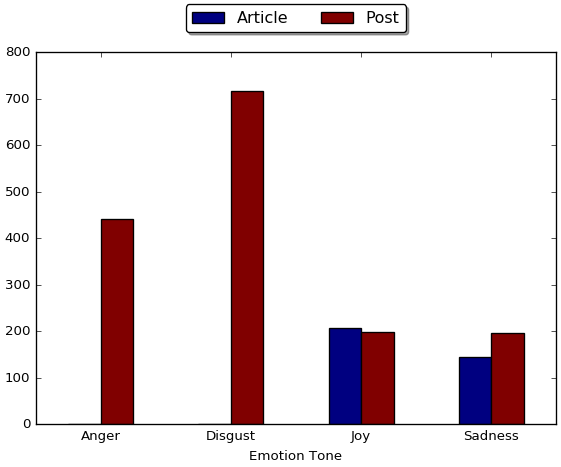

In [39]:
display(tones)

Now use a pie chart to identify how post consumption was broken up by language tone: 

1. Run the next cell.
1. Click the chart button and choose **Pie Chart**. 
1. In the chart options tool, drag `Lifetime Post Consumption` into the **Values** box and drag `Language Tone` into the **Keys** box. 
1. Set the Aggregation to **Avg** and click **OK**. 


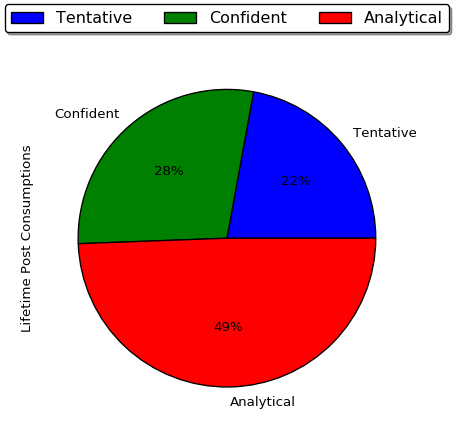

In [40]:
display(tones)

### <a id='viz2'></a>2.2 View post consumption by entity
Now look at how mean post consumption differs by entity:

1. Create a bar chart with a value of `Lifetime Post Consumption` and a key of `Entities`.
1. Cluster the results by `Type`.


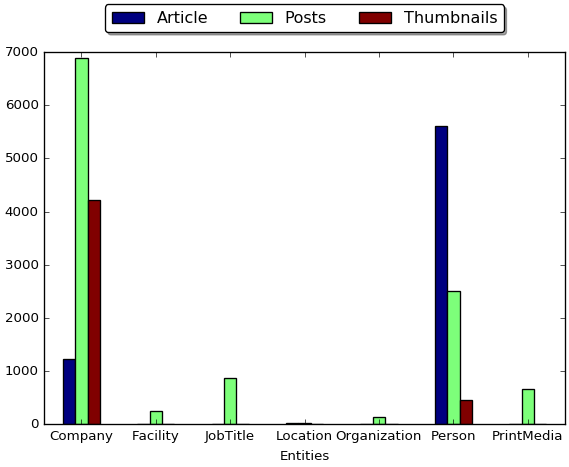

In [41]:
display(entities)

You can see that **Person** has the highest post consumption for articles, while **Company** has the highest for posts.

### <a id='viz3'></a>2.3 View post consumption by keyword
Finally, look at how post consumption is associated with certain keywords:

1. Create a bar chart with a value of `Lifetime Post Consumption` and a key of `Keywords`.
1. Cluster the results by `Type`.
1. Change the orientation to `horizontal`.


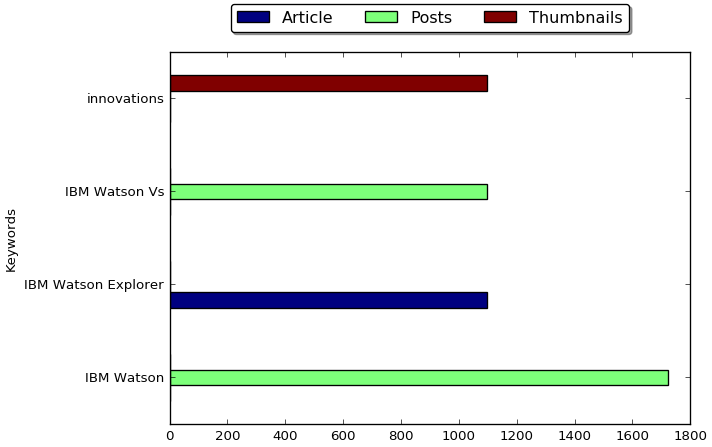

In [42]:
display(keywords)

Now try creating your own graphs with PixieDust!

## <a id='summary'></a>Summary 

You learned how to enrich data with three Watson services and how to visualize data with PixieDust.

You have these reusable resources for further exploration:

 - A function for saving a DataFrame to your project object storage when you're using Python 3.5.
 - A data file with enriched data that you can analyze in another notebook.
 - Enrichment scripts for each Watson service that you can easily adapt for your own uses.

Learn more about PixieDust:
 - [PixieDust Documentation](https://ibm-cds-labs.github.io/pixiedust/index.html)
 - [PixieDust GitHub Repo](https://github.com/ibm-cds-labs/pixiedust)
 - [Welcome to PixieDust sample notebook](https://apsportal.ibm.com/exchange/public/entry/view/5b000ed5abda694232eb5be84c3dd7c1)

### Authors
Tyler Andersen and Anna Quincy are on the IBM Watson Accelerator’s Team. They specialize in combining the power of Watson Services with the Watson Data Platform.

<hr>
Copyright &copy; IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.